In [2]:
import nltk
from nltk.corpus import treebank
from collections import Counter, defaultdict
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\22anj\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


Accuracy: 0.9071


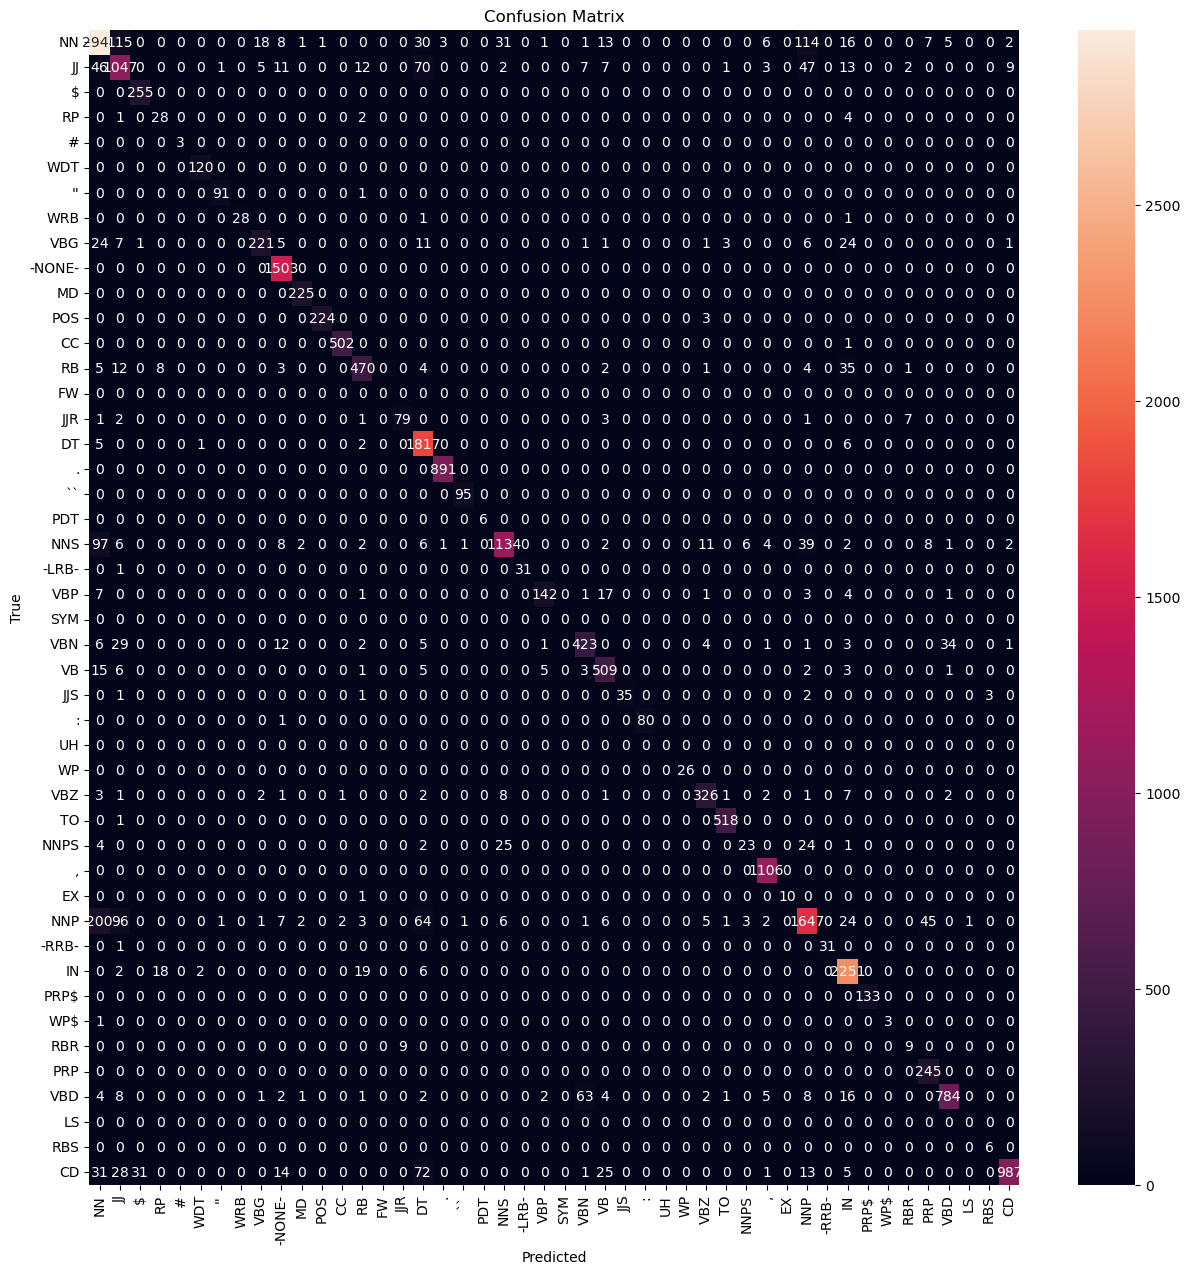

              precision    recall  f1-score   support

          NN       0.87      0.89      0.88      3320
          JJ       0.77      0.82      0.79      1283
           $       0.89      1.00      0.94       255
          RP       0.52      0.80      0.63        35
           #       1.00      1.00      1.00         3
         WDT       0.98      1.00      0.99       120
          ''       0.98      0.99      0.98        92
         WRB       1.00      0.93      0.97        30
         VBG       0.89      0.72      0.80       306
      -NONE-       0.95      1.00      0.98      1503
          MD       0.97      1.00      0.99       225
         POS       1.00      0.99      0.99       227
          CC       0.99      1.00      1.00       503
          RB       0.91      0.86      0.88       545
          FW       0.00      0.00      0.00         0
         JJR       0.90      0.84      0.87        94
          DT       0.87      0.99      0.93      1831
           .       1.00    

C:\Users\22anj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\22anj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\22anj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\22anj\anaconda3\Lib\site-packages\sklearn\metrics\_cla

In [3]:

# treebank dataset download
nltk.download('treebank')

# Load the dataset
train_data = treebank.tagged_sents()[:3000]  # Training data
test_data = treebank.tagged_sents()[3000:]   # Testing data

# Extract states and observations
states = set(tag for sentence in train_data for word, tag in sentence)
observations = set(word.lower() for sentence in train_data for word, tag in sentence)

# Calculate transition probabilities
transitions = defaultdict(Counter)
for sentence in train_data:
    previous_tag = '<s>'
    for word, tag in sentence:
        transitions[previous_tag][tag] += 1
        previous_tag = tag
    transitions[previous_tag]['</s>'] += 1

transition_probs = {
    prev_tag: {tag: count / sum(tag_counts.values()) for tag, count in tag_counts.items()}
    for prev_tag, tag_counts in transitions.items()
}

# Calculate emission probabilities
emissions = defaultdict(Counter)
for sentence in train_data:
    for word, tag in sentence:
        emissions[tag][word.lower()] += 1

emission_probs = {
    tag: {word: count / sum(word_counts.values()) for word, count in word_counts.items()}
    for tag, word_counts in emissions.items()
}

# Define the Viterbi algorithm for decoding
def viterbi(sequence, states, start_prob, transition_probs, emission_probs):
    V = [{}]
    path = {}
    for state in states:
        V[0][state] = start_prob[state] * emission_probs[state].get(sequence[0], 1e-6)
        path[state] = [state]

    for t in range(1, len(sequence)):
        V.append({})
        newpath = {}
        for state in states:
            (prob, best_prev_state) = max(
                (V[t-1][prev_state] * transition_probs[prev_state].get(state, 1e-6) *
                 emission_probs[state].get(sequence[t], 1e-6), prev_state)
                for prev_state in states
            )
            V[t][state] = prob
            newpath[state] = path[best_prev_state] + [state]
        path = newpath

    (prob, best_final_state) = max((V[-1][state], state) for state in states)
    return path[best_final_state]

# Evaluate the model on the test set
def evaluate_model(test_data, states, transition_probs, emission_probs):
    y_true = []
    y_pred = []
    for sentence in test_data:
        words = [word.lower() for word, tag in sentence]
        true_tags = [tag for word, tag in sentence]
        predicted_tags = viterbi(words, states, start_prob, transition_probs, emission_probs)
        y_true.extend(true_tags)
        y_pred.extend(predicted_tags)
    return y_true, y_pred

# Calculate the initial state probabilities (start probabilities)
start_prob = {state: transitions['<s>'].get(state, 1e-6) / sum(transitions['<s>'].values()) for state in states}

# Get true and predicted tags
y_true, y_pred = evaluate_model(test_data, states, transition_probs, emission_probs)

# Report accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(states))
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=states, yticklabels=states)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, labels=list(states)))
